# Preprocess Pilot Data 

## Goals:

1. **Data Import**
    - Import EEG data into MNE object.

2. **Preprocessing**
    - Preprocess the EEG data.
        * Bandpass filter
        * ICA
        * Autoreject bad channels
    - Epoch data based on stimulus appearance.
    
3. **Export Data**
    - Save organized epochs to an npz file
    - Save preprocessing settings to a json file
    
Want to make this as light as possible so only a few tweaks need to be made to run this in real-time

# Import Libraries

In [1]:
# Import libraries
import mne
from mne.preprocessing import ICA
from autoreject import Ransac 
import json
import numpy as np
import matplotlib.pyplot as plt

# Import custom scripts
from Functions import import_data
from Functions import data_tools

# Enable interactive plots
%matplotlib qt

## Hardcoded for P001 (Adam Luoma)

In [2]:
# import EEG data and fill settings
#file_name = "Masters_testing/sub-P001_ses-S001_task-T1_run-001_eeg.xdf"
#ch_names = ["Fp1", "Af3", "Fz", "C3", "C4", "Cp1", "Cp4", "Tp8", "P5", "P1", "PO7", "POz", "PO8", "O1", "Oz", "O2"]
#[eeg_ts, eeg_data, eeg_fs] = import_data.read_xdf(f"Data\\{file_name}", picks=ch_names)

# Create MNE array
#info = mne.create_info(ch_names, eeg_fs, ch_types = 'eeg')  # Create info properties
#mne_raw = mne.io.RawArray(eeg_data, info = info)    

# Fix mis-named channels for P001
#fixed_channels = {"Af3": "AF3", "Cp1": "CP1", "Cp4": "CP4", "Tp8": "TP8"}
#mne_raw.rename_channels(fixed_channels)
#updated_ch_names =  ["Fp1", "AF3", "Fz", "C3", "C4", "CP1", "CP4", "TP8", "P5", "P1", "PO7", "POz", "PO8", "O1", "Oz", "O2"]

# TEMP for misnamed channels
#ch_names = updated_ch_names

# Set standard channel montage
#mne_raw.set_montage('standard_1020')  

# Plot raw data
#mne_raw.plot(title="RAW data")   

# Import Data

Import EEG data
- Set channel names
    * **For P001, fix and update channel names**
- Create an mne raw object
- Set MNE channel montage

Creating RawArray with float64 data, n_channels=16, n_times=384256
    Range : 0 ... 384255 =      0.000 ...  1500.996 secs
Ready.
Using matplotlib as 2D backend.


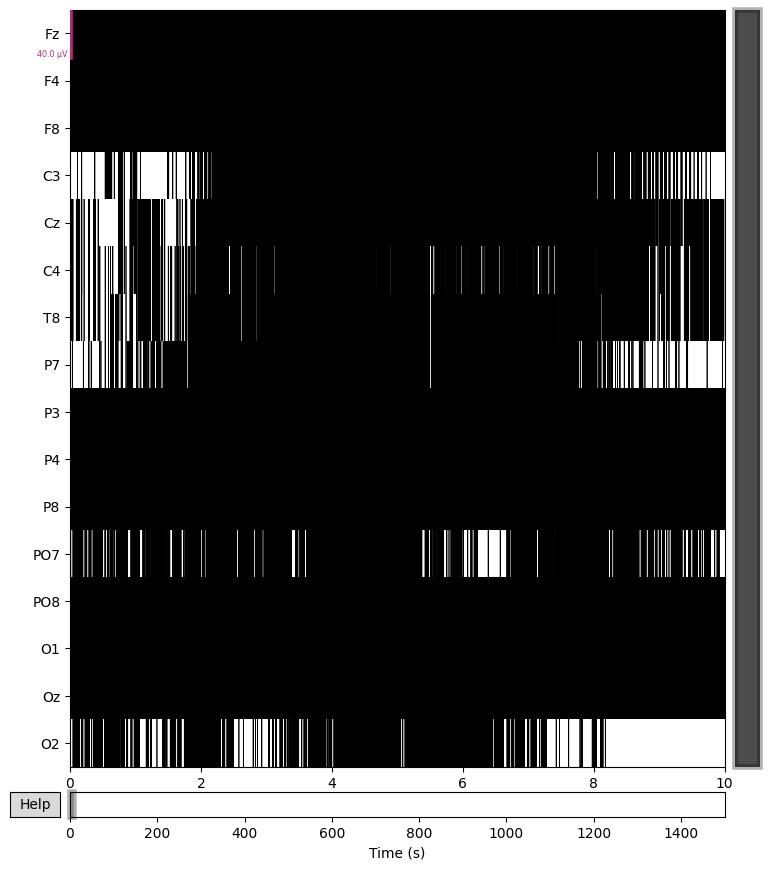

In [3]:
# import EEG data and fill settings
file_name = "Masters_testing/P002/sub-P002_ses-S001_task-T1_run-001_eeg.xdf"
ch_names = ["Fz", "F4", "F8", "C3", "Cz", "C4", "T8", "P7", "P3", "P4", "P8", "PO7", "PO8", "O1", "Oz", "O2"]
[eeg_ts, eeg_data, eeg_fs] = import_data.read_xdf(f"Data\\{file_name}", picks=ch_names)

# Create MNE array
info = mne.create_info(ch_names, eeg_fs, ch_types = 'eeg')  # Create info properties
mne_raw = mne.io.RawArray(eeg_data, info = info)            

# Set standard channel montage
mne_raw.set_montage('standard_1020')  

# Plot raw data
mne_raw.plot(title="RAW data")   

# Bandpass Filter Data

Stimulation frequency is 10 Hz, so filter between 0.5 Hz (highpass) and 35 Hz (lowpass)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1691 samples (6.605 s)



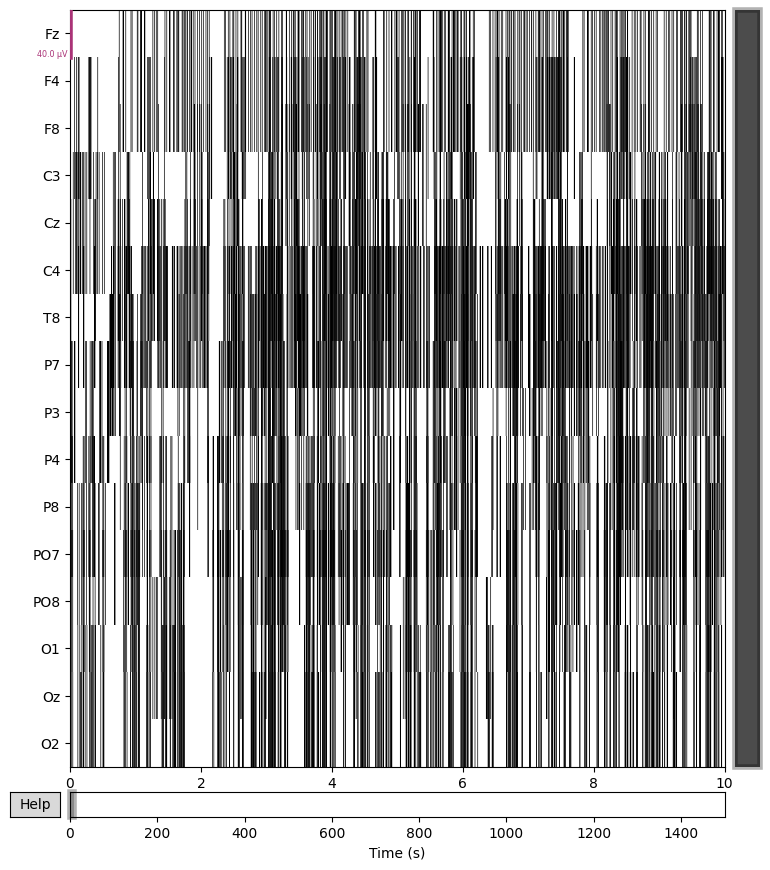

In [4]:
# Settings
hpf_fc = 0.5   # High-pass cut-off frequency: list[Hz]
lpf_fc = 35    # Low-pass cut-off frequency: list[Hz]

# Apply bandpass filter
filt_raw = mne_raw.copy().filter(l_freq=hpf_fc, h_freq=lpf_fc, picks=ch_names)

# Plot filtered data
filt_raw.plot()

# ICA
Perform ICA on the high-pass filtered data and manually select the components to be removed. A tutorial for the `MNE` ICA processing can be found [here](https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html).

Copmute the variance of each ICA component
- Reject the component if its variance is greater than 50%

In [5]:
# Settings
#n_components = len(filt_raw.ch_names)   # Number of components for ICA [n]
#random_state = 97                       # Random state for reproducible results
#max_iter = "auto"                       # Max number of iterations
#ch_properties = [0,1,2,3,4,5,6,7,8]     # Channels to inspect list[int]
#bad_components = []                     # Components to remove list[int]

# Create and apply ICA
#ica = ICA(
#    n_components = n_components,
#    max_iter = max_iter,
#    random_state = random_state
#    )

#ica.fit(filt_raw, picks = updated_ch_names)
#ica

# Plot ICA components on interactive plot
#ica.plot_components()

# Plot ICA properties
#ica.plot_properties(filt_raw, picks = ch_properties, verbose = False)

# Compute amount of variance explained by each component to inspect
#print("Variance explained")
#for component in ch_properties:
#    explained_var_ratio = ica.get_explained_variance_ratio(
#        filt_raw, 
#        components=component,
#        ch_type="eeg"
#    )
    
#    ratio_percent = round(100 * explained_var_ratio["eeg"])
#    if ratio_percent > 50:
#        bad_components.append(component)
#        print(f"- Component {component}: variance = {ratio_percent}% (BAD)")
#    print(f"- Component {component}: variance = {ratio_percent}%")

# Remove components
#ica_raw = filt_raw.copy()
#ica.exclude = bad_components
#ica_exclude = bad_components
#ica.apply(ica_raw)

# Plot before and after ICA to compare
#filt_raw.plot(title="BPF before ICA")
#ica_raw.plot(title="BPF after ICA")

# Automatically Detect Bad Channels
Using RANSAC bad channel detection built into `MNE` [link here](https://autoreject.github.io/stable/auto_examples/plot_ransac.html).
- Create RANSAC model
    * min_cor: Minimum correlation between channels to be considered as a good channel
    * n_resample: Number of resamples to use for RANSAC
    * min_channels: Minimum number of channels to be considered as a good channel
- Create 2 second epochs of whole timeseries EEG data
- Fit RANSAC model
    * Get the identified bad channels and remove them
    * Plot epoch averages before and after bad channel removal

In [6]:
# Initialize RANSAC for bad channel detection
ransac = Ransac(verbose=True, picks="eeg", n_jobs=1, min_corr= 0.75, n_resample = 100, min_channels = 0.25)

# Create epochs with preloading enabled
epochs = mne.make_fixed_length_epochs(filt_raw, duration=2, overlap=0.5, preload=True)

# Fit RANSAC to detect bad channels
ransac.fit(epochs)

# Print the identified bad channels
bad_channels = ransac.bad_chs_
print("Bad channels detected by RANSAC:")
print('\n'.join(bad_channels))

# Plot the evoked data before removing bad channels
evoked_before = epochs.average()
fig_before = evoked_before.plot(ylim={"eeg": (-5000000, 5000000)})  # Set Y-axis limits for EEG channels
fig_before.suptitle("Evoked Data (Before Removing Bad Channels)", fontsize=16)

# Remove bad channels from the raw object
ica_raw_clean = filt_raw.copy().drop_channels(bad_channels)

# Create new epochs without bad channels
epochs_clean = mne.make_fixed_length_epochs(ica_raw_clean, duration=2, overlap=0.5, preload=True)

# Plot the evoked data after removing bad channels
evoked_after = epochs_clean.average() 
fig_after = evoked_after.plot(ylim={"eeg": (-5000000, 5000000)})
fig_after.suptitle("Evoked Data (After Removing Bad Channels)", fontsize=16)

# Save the channel list without bad channels
ch_names_clean = [ch for ch in ch_names if ch not in bad_channels]

Not setting metadata
1000 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1000 events and 512 original time points ...
0 bad epochs dropped


  0%|          | interpolating channels : 0/100 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s


  0%|          | Iterating epochs : 0/1000 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   15.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   15.7s


[Done]
Bad channels detected by RANSAC:
C3
P4
O1
Not setting metadata
1000 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1000 events and 512 original time points ...
0 bad epochs dropped


# Epoch Data
Want to epoch the EEG data based on stimulus labels

This can look like 
1. [EEG]
2. [Stimulus Labels]
3. [Comfort Labels]

In [7]:
# Settings
list_of_events = []

for x in range(4):
    for y in range(3):
        list_of_events.append(f"Contrast{x+1}Size{y+1}")
epoch_end = "off- 10s"
#DANIELLA- epoch_end will be = "off- 10s"

[marker_ts, markers] = import_data.read_xdf_unity_markers(f"Data\{file_name}")    # Import markers

# Create Individual epochs for each event
[events_epochs, eeg_epochs] = data_tools.create_epochs(
    eeg_data = ica_raw_clean.get_data(), 
    eeg_ts = eeg_ts,
    markers = markers,
    markers_ts = marker_ts,
    events = list_of_events,
    epoch_end = epoch_end
    )

# Create a dict of stimuli using the unique events
dict_of_stimuli = {i: event for i, event in enumerate(list_of_events)}

# Organize epochs by stimuli and frequency
# Returns a list of organized EEG epochs in the shape [stimuli][trials][samples, chans].
# Example: eeg_epochs_organized[stim_inx] returns all epochs for a specific stimulus.
        # eeg_epochs_organized[stim_inx].shape returns the shape of the epochs for a specific stimulus. like (2, 13, 2560) for 2 trials, 13 channels and 2560 samples (10 seconds).
eeg_epochs_organized = data_tools.epochs_stim(
    eeg_epochs = eeg_epochs,
    labels = events_epochs,
    stimuli = dict_of_stimuli
    )

for stim_idx, stim_label in dict_of_stimuli.items():
    stim_epochs = eeg_epochs_organized[stim_idx]
    
    if len(stim_epochs) > 0:
        print(f"Stimulus: {stim_label}, Shape: {stim_epochs.shape}")
    else:
        print(f"Stimulus: {stim_label}, No epochs found")


Stimulus: Contrast1Size1, Shape: (2, 13, 2560)
Stimulus: Contrast1Size2, Shape: (2, 13, 2560)
Stimulus: Contrast1Size3, Shape: (3, 13, 2560)
Stimulus: Contrast2Size1, Shape: (3, 13, 2560)
Stimulus: Contrast2Size2, Shape: (4, 13, 2560)
Stimulus: Contrast2Size3, Shape: (2, 13, 2560)
Stimulus: Contrast3Size1, Shape: (4, 13, 2560)
Stimulus: Contrast3Size2, Shape: (3, 13, 2560)
Stimulus: Contrast3Size3, Shape: (3, 13, 2560)
Stimulus: Contrast4Size1, Shape: (6, 13, 2560)
Stimulus: Contrast4Size2, Shape: (3, 13, 2560)
Stimulus: Contrast4Size3, Shape: (5, 13, 2560)


In [8]:
list_of_off_events = ["off- 10s"]
epoch_end = "off- end"

# Create Individual epochs for each event
[baseline_epochs, eeg_baseline] = data_tools.create_epochs(
    eeg_data = ica_raw_clean.get_data(), 
    eeg_ts = eeg_ts,
    markers = markers,
    markers_ts = marker_ts,
    events = list_of_off_events,
    epoch_end = epoch_end
    )

dict_of_stimuli_2 = {0: "off- 10s"}

baseline_eeg_epochs_organized = data_tools.epochs_stim(
    eeg_epochs = eeg_baseline,
    labels = baseline_epochs,
    stimuli = dict_of_stimuli_2
    )

for stim_idx, stim_label in dict_of_stimuli_2.items():
    stim_epochs = baseline_eeg_epochs_organized[stim_idx]
    
    if len(stim_epochs) > 0:
        print(f"Stimulus: {stim_label}, Shape: {stim_epochs.shape}")
    else:
        print(f"Stimulus: {stim_label}, No epochs found")

Stimulus: off- 10s, Shape: (40, 13, 2560)


# Get RS Data Epoched (OLD)
 
Break into 6, 10 second epochs

In [9]:
# Eyes Open Resting State
#list_of_events = ["Resting State, Eyes Open"]
#epoch_end = "Resting State, Eyes Closed"

#[marker_ts, markers] = import_data.read_xdf_unity_markers(f"Data\{file_name}")    # Import markers

#[resting_open_epoch, eeg_resting_open] = data_tools.create_epochs_resting(
#    eeg_data = ica_raw_clean.get_data(), 
#    eeg_ts = eeg_ts,
#    markers = markers,
#    markers_ts = marker_ts,
#    events = list_of_events,
#    epoch_end = epoch_end
#    )

# split the resting state epoch into multiple epochs
#epoch = eeg_resting_open  
#split_epochs = data_tools.split_epoch_into_multiple(epoch, 6) #breaks the epoch into 6 epochs

#dict_of_stimuli_2 = {0: "Resting State, Eyes Open"}

#eeg_epochs_organized_RS_open = data_tools.epochs_stim(
#    eeg_epochs = split_epochs,
#    labels = resting_open_epoch,
#    stimuli = dict_of_stimuli_2
#    )

#for stim_idx, stim_label in dict_of_stimuli_2.items():
#    stim_epochs = eeg_epochs_organized_RS_open[stim_idx]
    
#    if len(stim_epochs) > 0:
#        print(f"Stimulus: {stim_label}, Shape: {stim_epochs.shape}")
#    else:
#        print(f"Stimulus: {stim_label}, No epochs found")

#Eyes Closed Resting State
#list_of_events = ["Resting State, Eyes Closed"]
#epoch_end = "Pair number1"

#[resting_closed_epoch, eeg_resting_closed] = data_tools.create_epochs_resting(
#    eeg_data = ica_raw_clean.get_data(), 
#    eeg_ts = eeg_ts,
#    markers = markers,
#    markers_ts = marker_ts,
#    events = list_of_events,
#    epoch_end = epoch_end
#    )

#dict_of_stimuli_3 = {0: "Resting State, Eyes Closed"}

#eeg_epochs_organized_RS_closed = data_tools.epochs_stim(
#    eeg_epochs = eeg_resting_closed,
#    labels = resting_closed_epoch,
#    stimuli = dict_of_stimuli_3
#    )

# Save RS Open Epoch to npy file (OLD)

In [10]:
#save_data = False

#if (save_data):
#    npy_file_name = file_name.split("\\")[-1].split(".")[0]

#    np.save(
#        f"Data\\{npy_file_name}_open.npy",
#        eeg_epochs_organized_RS_open,
#        )

In [11]:
save_data = True

if save_data:
    npz_file_name = file_name.split("\\")[-1].split(".")[0]

    # Create a dictionary to store each stimulus separately
    save_dict = {stim_label: np.array(baseline_eeg_epochs_organized[stim_idx]) 
                 for stim_idx, stim_label in dict_of_stimuli_2.items()}

    # Save using np.savez to preserve structure
    np.savez(f"Data\\{npz_file_name}_baseline.npz", **save_dict)

    print(f"Saved organized epochs to Data\\{npz_file_name}_baseline.npz")

Saved organized epochs to Data\Masters_testing/P002/sub-P002_ses-S001_task-T1_run-001_eeg_baseline.npz


# Save Organized Epochs to npz file
Can't use regular npy because each stimulus may have a different number of epochs (i.e. a different shape)

In [12]:
save_data = True

if save_data:
    npz_file_name = file_name.split("\\")[-1].split(".")[0]

    # Create a dictionary to store each stimulus separately
    save_dict = {stim_label: np.array(eeg_epochs_organized[stim_idx]) 
                 for stim_idx, stim_label in dict_of_stimuli.items()}

    # Save using np.savez to preserve structure
    np.savez(f"Data\\{npz_file_name}.npz", **save_dict)

    print(f"Saved organized epochs to Data\\{npz_file_name}.npz")

Saved organized epochs to Data\Masters_testing/P002/sub-P002_ses-S001_task-T1_run-001_eeg.npz


# Save settings to json

In [13]:
# Settings
save_model = True 

if (save_model):
    json_data = {
        "file_name": file_name,
        "eeg_srate": eeg_fs,
        "ch_names": ch_names,
        "bad_chans": bad_channels,
        "new_ch_names": ch_names_clean,
        "hpf_fc": hpf_fc,
        "lpf_fc": lpf_fc,
        #"ica_exclude": ica_exclude,
        #"n_components": n_components,
        #"random_state": random_state,
        #"max_iter": max_iter,
        "labels": markers,
        "stimuli": dict_of_stimuli
        }

    # Get file name without extension
    json_file_name = file_name.split("\\")[-1].split(".")[0]
    
    # Write dictionary to json file
    with open(f"Data\\{json_file_name}.json", "w") as f:
        json.dump(json_data, f)